In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import pickle  # Pour sauvegarder l'état de PCAx

# Matplotlib settings
from matplotlib import rcParams

# Scikit-learn modules
import pcax 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Keras (deep learning)
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.losses import MeanSquaredError, Huber, MeanAbsoluteError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l1, l2, l1_l2
from pathlib import Path

# again, this only works on startup!
import jax
jax.config.update("jax_enable_x64", True)

2025-03-24 11:03:36.590263: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Theta shape : (100000, 3)
Spectrum shape : (100000, 10000)
X_train shape: (90000, 3), X_test shape: (10000, 3)
y_train shape: (90000, 20), y_test shape: (10000, 20)
Variance explained by the 20 first components : 99.9336%


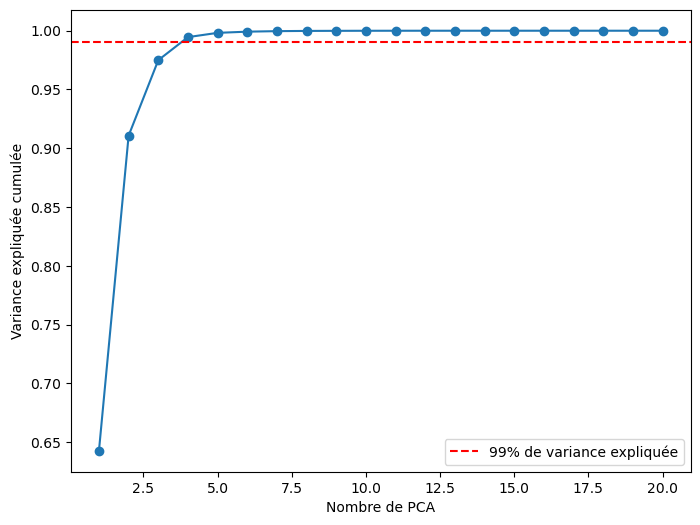

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import pcax  # Assure-toi que pcax est bien importé

# 📌 Chargement des simulations
data_path = Path("/Users/xifumacbook/Documents/Codes/Spectres/compTT/comptt_Didier_approved.npz")  # Modifier selon ton répertoire
data = np.load(data_path)

# Extraction des simulations et des paramètres
spectres = data["simulations"]
theta = data["theta"]

# Suppression des colonnes non nécessaires dans theta (redshift, approx, norm)
theta = np.delete(theta, [0, 4, -1], axis=1)  # Indices à adapter si besoin

# Vérification des dimensions
print(f"Theta shape : {theta.shape}")  # Paramètres
print(f"Spectrum shape : {spectres.shape}")  # Spectres simulés

#spectres = np.random.poisson(lam=np.abs(spectres))

# Transformation log des spectres
spectres = np.log1p(spectres)

# Normalisation sur l'ensemble des données
scaler_theta = RobustScaler()
scaler_spectre = MinMaxScaler()

#theta_scaled = scaler_theta.fit_transform(theta)
theta_scaled = theta
spectres_scaled = scaler_spectre.fit_transform(spectres)

# PCA sur les spectres normalisés
n_PCA = 20
pca_state = pcax.fit(spectres_scaled, n_components=n_PCA    )
spectres_pca = pcax.transform(pca_state, spectres_scaled)

# Division des données après transformations
X_train, X_test, y_train, y_test = train_test_split(theta_scaled, spectres_pca, test_size=0.1, random_state=42)

# Vérification post-split
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# Variance expliquée par la PCA
explained_variance = np.sum(y_train.var(axis=0)) / np.sum(spectres_pca.var(axis=0))
print(f"Variance explained by the {n_PCA} first components : {explained_variance:.4%}")

# Calcul de la variance expliquée par composante
explained_variance_per_component = y_train.var(axis=0) / np.sum(y_train.var(axis=0))
cumulative_variance = np.cumsum(explained_variance_per_component)

# Plot de la variance expliquée
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_per_component) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.99, color='r', linestyle='--', label="99% de variance expliquée")
plt.xlabel("Nombre de PCA")
plt.ylabel("Variance expliquée cumulée")
plt.legend()
plt.show()

# # Save PCA state
# with open("comptt_pca.pkl", "wb") as f:
#     pickle.dump(pca_state, f)


In [ ]:
from keras.losses import LogCosh, Huber
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 📌 **Définition de la fonction de perte combinée**
def combined_loss(y_true, y_pred):
    huber = Huber(delta=5.5)(y_true, y_pred)  # Ajuste delta si besoin
    logcosh = LogCosh()(y_true, y_pred)
    return huber + logcosh  # Addition des pertes

# =======================
# Model Building
# =======================

def TTNN(input_dim, output_dim, learning_rate=1e-4):
    model = Sequential([
        Dense(256, activation='selu', input_shape=(input_dim,)),
        Dense(256, activation='selu'),
        Dense(256, activation='selu'),
        #Dropout(0.1),
        Dense(256, activation='selu'),
        Dense(output_dim, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=MeanSquaredError()
        # Huber(5.5)  # Utilisation de la perte combinée
        #MeanAbsoluteError()
    )
    
    return model

input_dim = X_train.shape[1]  
output_dim = y_train.shape[1]   
model = TTNN(input_dim, output_dim)
model.summary()

# =======================
# Training
# =======================

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# 📌 **Entraînement du modèle**
history = model.fit(
    X_train, y_train,
    validation_split=0.1,  
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# model.save("comptt_model.keras")


/Users/xifumacbook/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,540 (795.08 KB)

 Trainable params: 203,540 (795.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 4.4046 - val_loss: 0.0838 - learning_rate: 1.0000e-04
Epoch 2/500
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0596 - val_loss: 0.0207 - learning_rate: 1.0000e-04
Epoch 3/500
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0198 - val_loss: 0.0144 - learning_rate: 1.0000e-04
Epoch 4/500
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0122 - val_loss: 0.0083 - learning_rate: 1.0000e-04
Epoch 5/500
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0079 - val_loss: 0.0092 - learning_rate: 1.0000e-04
Epoch 6/500
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 0.0062 - val_loss: 0.0042 - learning_rate: 1.0000e-04
Epoch 7/500
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0053 - val_loss: 0.0034 - learning_rate: 1.0000e-04
Epoch 8/500
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0049 - val_loss: 0.0037 - learning_rate: 1.0000e-04
Epoch 9/500
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/ste

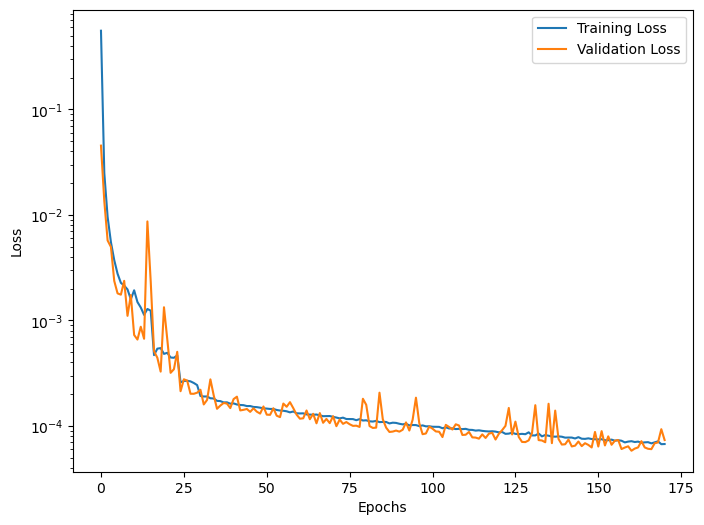

In [ ]:
# =======================
# Plotting Loss
# =======================

def plot_loss(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.yscale('log')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =======================
# Plotting Spectra
# =======================


# 📌 **Reconstruction des spectres**
def reconstruct_spectra(pca_state, scaler_spectre, y_pca):
    y_scaled = pcax.recover(pca_state, y_pca)
    y_log = scaler_spectre.inverse_transform(y_scaled)
    return np.expm1(y_log)  # Conversion inverse du log1p

# 📌 **Analyse d'un échantillon spécifique**
def plot_sample(idx):
    theta_sample = X_test[idx:idx+1]  # Échantillon unique pour la prédiction

    # 📌 **Prédiction dans l'espace des PCA**
    spectrum_true_pca = y_test[idx]  # Maintenant `y_test` est déjà en PCA
    spectrum_pred_pca = model.predict(theta_sample)[0]

    # 📌 **Inversion de la PCA et du scaling**
    spectrum_true_orig = reconstruct_spectra(pca_state, scaler_spectre, spectrum_true_pca.reshape(1, -1)).flatten()
    spectrum_pred_orig = reconstruct_spectra(pca_state, scaler_spectre, spectrum_pred_pca.reshape(1, -1)).flatten()

    # 📌 **Calcul de l'erreur relative**
    eps = 1e-8
    error_bin = (spectrum_true_orig - spectrum_pred_orig) / (np.abs(spectrum_true_orig) + eps) * 100
    global_error = 100 * np.linalg.norm(spectrum_true_orig - spectrum_pred_orig) / np.linalg.norm(spectrum_true_orig)

    print(f"Sample {idx} | Relative overall error : {global_error:.3f}%")

    # 📌 **Création de l'échelle d'énergie**
    e_min, e_max, num_bins = 0.1, 50, spectrum_true_orig.shape[0]  
    energy_array = np.geomspace(e_min, e_max, num_bins)

    # 📌 **Récupération des paramètres originaux**
    theta_orig = X_test[idx]
    
    # Noms des paramètres avec notation mathématique (ajustés pour le modèle comptb)
    param_names = [r"$T_0$", r"$kT$", r"$\tau_p$"]

    # 📌 **Affichage des paramètres**
    print("Parameters used for the sample:")
    for name, value in zip(param_names, theta_orig):
        print(f" - {name}: {value:.4f}")

    param_str = ", ".join([f"{name}={value:.3f}" for name, value in zip(param_names, theta_orig)])

    # 📌 **Affichage des résultats**
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True)
    
    # **Comparaison des spectres**
    ax1.semilogx(energy_array, spectrum_pred_orig, label='Reconstructed spectrum', color='blue')
    ax1.semilogx(energy_array, spectrum_true_orig, label='Original spectrum', color='red', linestyle="dashed")
    ax1.set_ylabel("Intensity")
    ax1.set_xlabel("Energy (keV)")
    ax1.legend()
    ax1.set_title(f"Sample {idx}\n{param_str}", fontsize=10)

    # **Erreur relative**
    ax2.plot(energy_array, error_bin, label="Relative error (%)", color='red')
    ax2.fill_between(energy_array, 0, error_bin, color='red', alpha=0.3)
    ax2.set_xlabel("Energy (keV)")
    ax2.set_ylabel("Error (%)")
    ax2.legend()

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Sample 1484 | Relative overall error : 2.494%
Parameters used for the sample:
 - $T_0$: 0.1059
 - $kT$: 5.9286
 - $\tau_p$: 0.5744


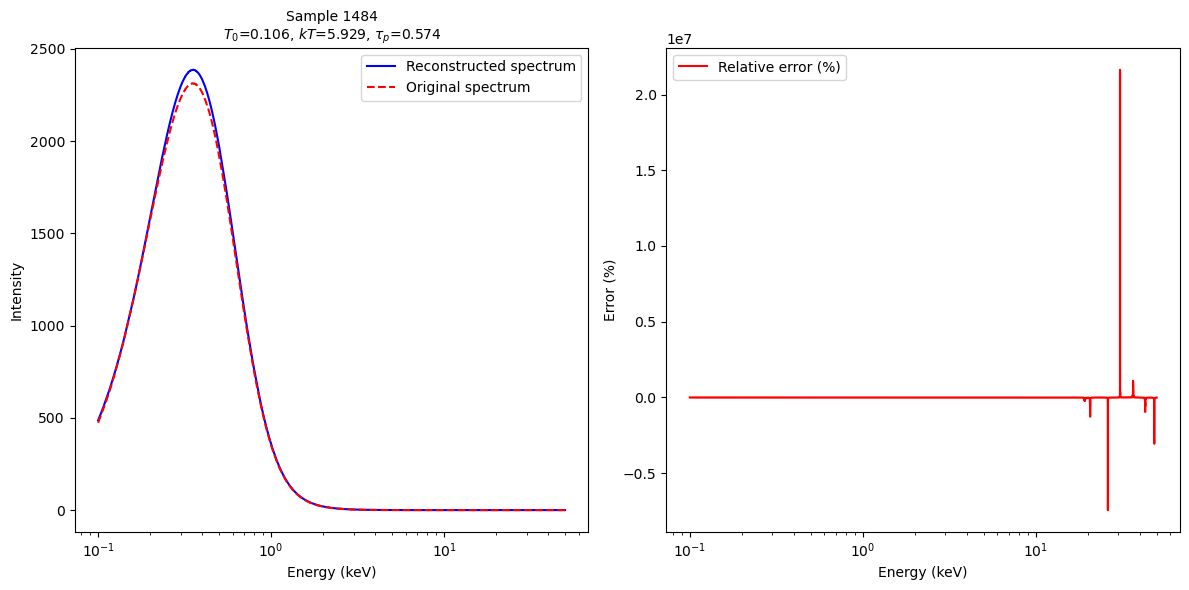

In [11]:
plot_sample(1484)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
X_test shape: (10000, 3)
Global_errors shape: (10000,)

 Nombre de spectres avec une erreur > 3% : 50
Indices des spectres concernés : [  84  154  502  545  904 1365 1484 1497 1945 1961 2142 2352 2357 2590
 2656 2936 3274 3668 3856 3974 4406 4640 4729 4822 4844 4871 4969 5086
 5310 6243 6281 6402 6646 6716 6848 6854 7085 7178 7248 7284 7424 7921
 8400 8652 8681 8833 9271 9794 9967 9973]

 Spectre avec l'erreur maximale : Index 1484
   - Erreur : 2.494%
   - Paramètres associés :
     $T_0$: 0.1059
     $kT$: 5.9286
     $\tau_p$: 0.5744


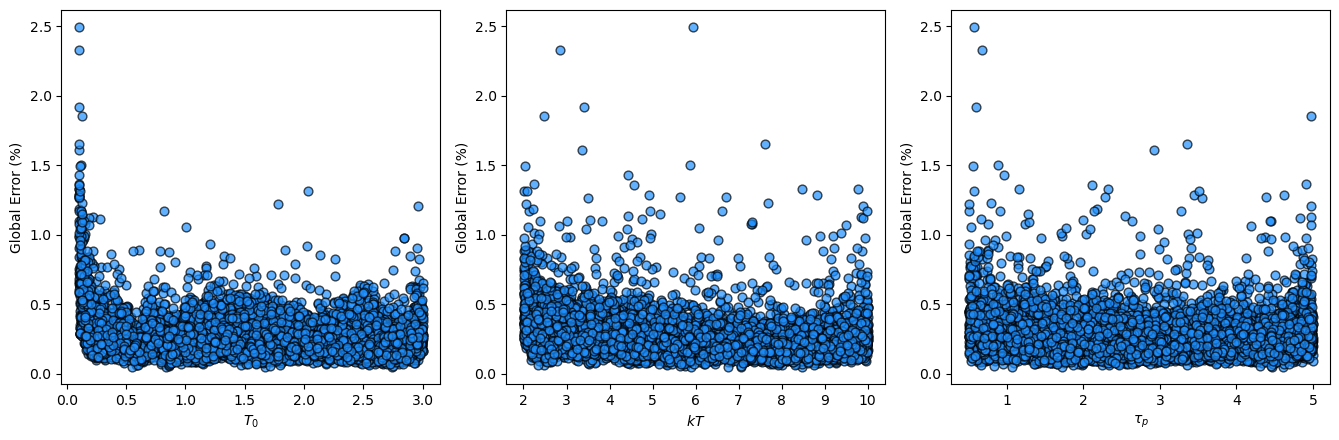


 Indices des spectres avec erreur > 3% : [  84  154  502  545  904 1365 1484 1497 1945 1961 2142 2352 2357 2590
 2656 2936 3274 3668 3856 3974 4406 4640 4729 4822 4844 4871 4969 5086
 5310 6243 6281 6402 6646 6716 6848 6854 7085 7178 7248 7284 7424 7921
 8400 8652 8681 8833 9271 9794 9967 9973]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 📌 **Reconstruction des spectres**
def reconstruct_spectra(pca_state, scaler_spectre, y_pca):
    """
    Transforme les spectres depuis l'espace PCA vers l'espace original :
    1. Annulation de la PCA.
    2. Annulation du standard scaling.
    3. Annulation de la transformation log1p.
    """
    y_scaled = pcax.recover(pca_state, y_pca)  # Annulation de la PCA
    y_log = scaler_spectre.inverse_transform(y_scaled)  # Annulation du standard scaling
    return np.expm1(y_log)  # Annulation du log1p

# 📌 **Analyse des erreurs globales**
def plot_global_errors_per_theta(model, X_test, y_test, pca_state, pcax, scaler_spectre, custom_legends=None):
    """
    Trace les erreurs globales pour chaque spectre en fonction des 3 paramètres theta,
    et identifie les spectres avec une erreur > 3%.
    """
    
    eps = 1e-8

    # 📌 **Prédictions du modèle**
    y_pred_pca = model.predict(X_test)

    # 📌 **Reconstruction des spectres**
    y_test_orig = reconstruct_spectra(pca_state, scaler_spectre, y_test)
    y_pred_orig = reconstruct_spectra(pca_state, scaler_spectre, y_pred_pca)

    # 📌 **Calcul des erreurs globales**
    global_errors = [
        100 * np.linalg.norm(true_spectrum - pred_spectrum) / np.linalg.norm(true_spectrum + eps)
        for true_spectrum, pred_spectrum in zip(y_test_orig, y_pred_orig)
    ]
    global_errors = np.array(global_errors)

    # 📌 **Vérification des formes**
    print(f"X_test shape: {X_test.shape}")
    print(f"Global_errors shape: {global_errors.shape}")

    # 📌 **Indices des spectres avec erreur > 3%**
    high_error_indices = np.where(global_errors > 1)[0]
    num_high_errors = len(high_error_indices)

    print(f"\n Nombre de spectres avec une erreur > 3% : {num_high_errors}")
    if num_high_errors > 0:
        print(f"Indices des spectres concernés : {high_error_indices}")

    # 📌 **Transformation inverse des paramètres theta**
    theta_orig = X_test  # Pas de normalisation des paramètres
    
    theta_names = [r"$T_0$", r"$kT$", r"$\tau_p$"]

    # 📌 **Spectre avec l'erreur maximale**
    if num_high_errors > 0:
        worst_idx = np.argmax(global_errors)  # Trouver le spectre avec l'erreur max
        print(f"\n Spectre avec l'erreur maximale : Index {worst_idx}")
        print(f"   - Erreur : {global_errors[worst_idx]:.3f}%")

        # Mise à jour des paramètres **(Seulement 3 paramètres !)**
        theta_names = [r"$T_0$", r"$kT$", r"$\tau_p$"]

        print(f"   - Paramètres associés :")
        for name, value in zip(theta_names, theta_orig[worst_idx]):
            print(f"     {name}: {value:.4f}")

    # 📌 **Tracer les erreurs par paramètre**
    num_params = len(theta_names)
    cols = 3
    rows = (num_params + cols - 1) // cols  # Adaptation dynamique du nombre de lignes

    fig, axes = plt.subplots(rows, cols, figsize=(4.5 * cols, 4.5 * rows))
    axes = axes.flatten()  # Rendre les axes indexables même si une seule ligne

    for i, param_name in enumerate(theta_names):
        axes[i].scatter(theta_orig[:, i], global_errors, color='dodgerblue', alpha=0.7, edgecolor='black', s=40)

        # 📌 **Utilisation des légendes personnalisées**
        xlabel = custom_legends[param_name]["xlabel"] if custom_legends and param_name in custom_legends else param_name
        ylabel = custom_legends[param_name]["ylabel"] if custom_legends and param_name in custom_legends else "Global Error (%)"

        axes[i].set_xlabel(xlabel)
        axes[i].set_ylabel(ylabel)


    # Supprimer les subplots vides
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return high_error_indices  # 📌 Retourne les indices des spectres avec erreur > 3%

# 📌 **Légendes personnalisées (Seulement 3 paramètres)**
custom_legends = {
    r"$\alpha$": {"xlabel": r"$\alpha$", "ylabel": "Global Error (%)"},
    r"$\delta$": {"xlabel": r"$\delta$", "ylabel": "Global Error (%)"},
    r"$kT_e$": {"xlabel": r"$kT_e$ (keV)", "ylabel": "Global Error (%)"},
}

# 📌 **Exécution de l'analyse**
high_error_indices = plot_global_errors_per_theta(
    model=model,
    X_test=X_test,
    y_test=y_test,  # On passe directement y_test
    pca_state=pca_state,
    pcax=pcax,
    scaler_spectre=scaler_spectre,
    custom_legends=custom_legends
)

print(f"\n Indices des spectres avec erreur > 3% : {high_error_indices}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


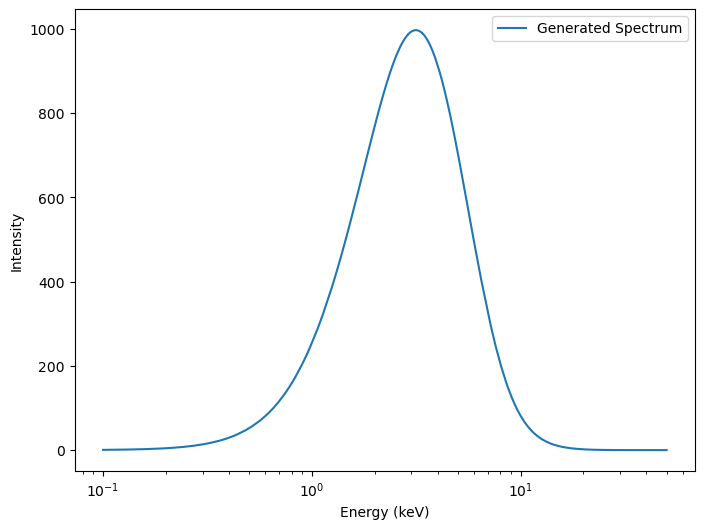

In [ ]:
def generate_spectrum(T_0, kT, tau_p):
    """
    Génère un spectre en fonction des paramètres d'entrée.
    """
    # 📌 **Création de l'entrée du modèle**
    theta_input = np.array([[T_0, kT, tau_p]])  # Mise en forme en tableau
    
    # 📌 **Prédiction dans l'espace des PCA**
    spectrum_pred_pca = model.predict(theta_input)[0]

    # 📌 **Inversion de la PCA et du scaling**
    spectrum_pred_orig = reconstruct_spectra(pca_state, scaler_spectre, spectrum_pred_pca.reshape(1, -1)).flatten()
    
    # 📌 **Création de l'échelle d'énergie**
    e_min, e_max, num_bins = 0.1, 50, spectrum_pred_orig.shape[0]  
    energy_array = np.geomspace(e_min, e_max, num_bins)
    
    # 📌 **Affichage des paramètres**
    param_names = [r"$T_0$", r"$kT$", r"$\tau_p$"]
    param_str = ", ".join([f"{name}={value:.3f}" for name, value in zip(param_names, [T_0, kT, tau_p])])
    
    # 📌 **Affichage du spectre**
    plt.figure(figsize=(8, 6))
    plt.semilogx(energy_array, spectrum_pred_orig, label='Generated Spectrum')
    plt.xlabel("Energy (keV)")
    plt.ylabel("Intensity")
    plt.legend()

    plt.show()

# 📌 **Exemple d'utilisation**
T_0_example, kT_example, tau_p_example = 1, 3.209, 1.789  # Modifier avec les valeurs souhaitées
generate_spectrum(T_0_example, kT_example, tau_p_example)